# Q-Learning

In [1]:
import matplotlib.pyplot as plt
import os
import random
import sys

cwd = os.getcwd()

parentdir = os.path.dirname(cwd)
sys.path.insert(0, parentdir)

from environments.tic_tac_toe.tic_tac_toe import TicTacToe
from environments.game import PlayRoom

In [2]:
playroom = PlayRoom(game = TicTacToe())

class Transistion():
  def __init__(self, state_code: str, action: int, reward: int, next_state_code: str):
    self.state_code = state_code
    self.action = action
    self.next_state_code = next_state_code
    self.reward = reward

In [3]:
##EPSILON STILL NEEDED

class QLearning():
  def __init__(self, learning_rate: float, discount_factor: float, epsilon: float):
    self.Q_table = {}
    self.playroom = PlayRoom(game = TicTacToe())
    self.epsilon = epsilon
    self.learning_rate = learning_rate
    self.discount_factor = discount_factor

  def determine_discount_factor(self):
    df = 0.1
    while df < 1.0:
      print(f"df: {df}")
      self.discount_factor = df
      self.reset()
      eval_x, eval_y = self.learn(n_epochs = 100_000, eval_freq = 1_000, num_eval_episodes = 500)
      plt.plot(eval_x, eval_y, label = f'{df}')
      df += 0.1
    
    plt.legend()
    plt.title('Peformance during training for different discount factors')
    plt.ylabel('Trained epochs')
    plt.xlabel('Average evaluation reward')
    plt.show()
    
  def determine_epsilon(self):
    eps = 0.1
    while eps < 1.0:
      print(f"eps: {eps}")
      self.epsilon = eps
      self.reset()
      eval_x, eval_y = self.learn(n_epochs = 100_000, eval_freq = 1_000, num_eval_episodes = 500)
      plt.plot(eval_x, eval_y, label = f'{eps}')
      eps += 0.1
    
    plt.legend()
    plt.title('Peformance during training for different epsilons')
    plt.ylabel('Trained epochs')
    plt.xlabel('Average evaluation reward')
    plt.show()

  def determine_learning_rate(self):
    lr = 0.1
    while lr < 0.9:
      print(f"lr: {lr}")
      self.learning_rate = lr
      self.reset()
      eval_x, eval_y = self.learn(n_epochs = 100_000, eval_freq = 1_000, num_eval_episodes = 500)
      plt.plot(eval_x, eval_y, label = f'{lr}')
      lr += 0.1
    
    plt.legend()
    plt.title('Peformance during training for different learning rates')
    plt.ylabel('Trained epochs')
    plt.xlabel('Average evaluation reward')
    plt.show()

  def reset(self):
    self.Q_table = {}

  def learn(self, n_epochs: int, eval_freq: int, num_eval_episodes: int, early_stop: bool = True, early_stop_num: int = 10):
    self.playroom.reset()
    done = False

    eval_y = []
    eval_x = []
    highest_eval = 0
    not_improved = 0

    for epoch in range(n_epochs):
      action = self._determine_action(deterministic = False)
      state_action_code = f'{self.playroom.game_state_code}-{action}'

      if state_action_code not in self.Q_table.keys():
        self.Q_table[state_action_code] = 0

      _, reward, done, _, _ = self.playroom.step(action = action)
      
      if done:
        self.playroom.reset()
        self.Q_table[state_action_code] = (1 - self.learning_rate) * self.Q_table[state_action_code] + self.learning_rate * (reward)
      
      else:
        next_optimal_state_action_code = f'{self.playroom.game_state_code}-{self._determine_action(deterministic = True)}'

        if next_optimal_state_action_code not in self.Q_table.keys():
          self.Q_table[next_optimal_state_action_code] = 0

        self.Q_table[state_action_code] = (1 - self.learning_rate) * self.Q_table[state_action_code] + self.learning_rate * (reward + self.discount_factor * self.Q_table[next_optimal_state_action_code])

      if (epoch + 1) % eval_freq == 0:
        eval_y.append(self._evaluate(num_eval_episodes = num_eval_episodes))
        eval_x.append(epoch + 1)

        if highest_eval < eval_y[-1]:
          highest_eval = eval_y[-1]
          not_improved = 0
        else:
          not_improved += 1

        print(f'Evaluate {eval_x[-1]}/{n_epochs}: {eval_y[-1]}')
        self.playroom.reset()

        if early_stop and not_improved > early_stop_num:
          break
    
    plt.plot(eval_x, eval_y)
    plt.title('Average reward during evalation')
    plt.xlabel("Trained number of epochs")
    plt.ylabel('Average reward')
    plt.show()

    return eval_x, eval_y


  def _determine_action(self, deterministic):
    if random.random() < self.epsilon and not deterministic:
      return random.choice(self.playroom.possible_actions)
    
    state_code = self.playroom.game_state_code
    state_q_values = {k: v for k, v in self.Q_table.items() if state_code in k}

    if len(state_q_values) == 0:
      return random.choice(self.playroom.possible_actions)
    
    max_state_action = max(state_q_values, key = state_q_values.get)
    return int(max_state_action.split('-')[-1])
  
  def _evaluate(self, num_eval_episodes: int):
    total_reward = 0
    for _ in range(num_eval_episodes):
      self.playroom.reset()
      done = False
      while not done:
        _, reward, done, _, _ = self.playroom.step(action = self._determine_action(deterministic = True))
      total_reward += reward
    return total_reward / num_eval_episodes

Evaluate 1000/100000: -0.18
Evaluate 2000/100000: -0.124
Evaluate 3000/100000: 0.0
Evaluate 4000/100000: 0.016
Evaluate 5000/100000: 0.14
Evaluate 6000/100000: 0.132
Evaluate 7000/100000: 0.176
Evaluate 8000/100000: 0.16
Evaluate 9000/100000: 0.156
Evaluate 10000/100000: 0.324
Evaluate 11000/100000: 0.356
Evaluate 12000/100000: 0.416
Evaluate 13000/100000: 0.436
Evaluate 14000/100000: 0.42
Evaluate 15000/100000: 0.324
Evaluate 16000/100000: 0.388
Evaluate 17000/100000: 0.388
Evaluate 18000/100000: 0.408
Evaluate 19000/100000: 0.464
Evaluate 20000/100000: 0.492
Evaluate 21000/100000: 0.488
Evaluate 22000/100000: 0.5
Evaluate 23000/100000: 0.492
Evaluate 24000/100000: 0.5
Evaluate 25000/100000: 0.532
Evaluate 26000/100000: 0.548
Evaluate 27000/100000: 0.444
Evaluate 28000/100000: 0.584
Evaluate 29000/100000: 0.58
Evaluate 30000/100000: 0.552
Evaluate 31000/100000: 0.524
Evaluate 32000/100000: 0.624
Evaluate 33000/100000: 0.484
Evaluate 34000/100000: 0.64
Evaluate 35000/100000: 0.616
Eval

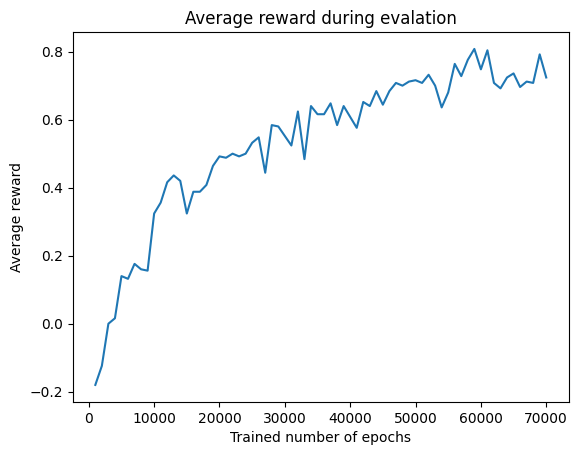

In [4]:
q_learing = QLearning(learning_rate = 0.3, discount_factor = 0.9, epsilon = 0.5)
x,y = q_learing.learn(100_000, eval_freq = 1_000, num_eval_episodes = 500)
# q_learing.determine_epsilon()